---
# Lazy Transport Map Variational Inference

## 8. Approximate Posterior Sampling via Normalizing Flows (LazyDINO)

Having trained a DINO surrogate $\boldsymbol{V}\mathbf{g}_w(\mathcal{E}_r m) \approx \mathcal{G}(m)$, we can use it for **fast Bayesian inversion**: given observed data $\mathbf{y}$, approximate the posterior $\mu_{m|y}$ without any further PDE solves.

### Latent log-posterior

In the reduced coordinate system $z = \mathcal{E}_r  m \in \mathbb{R}^r$, the surrogate posterior density (with respect to Lebesgue measure) takes the form

$$\log \tilde{\pi}_{z \mid \mathbf{y}}(z \mid \mathbf{y}) \;=\; \underbrace{-\frac{1}{2\sigma^2}\bigl\|\mathbf{y} - \mathbf{g}_w(z)\bigr\|^2}_{\text{surrogate log-likelihood}} \;-\; \underbrace{\tfrac{1}{2}\|z\|^2}_{\text{latent prior}} \;+\; \mathrm{const},$$

where the prior term is $\mathcal{N}(0, I_r)$ because the reduced basis is orthonormalized with respect to the prior covariance.

### Training a normalizing flow

We fit a **masked autoregressive flow** (MAF) ${T_{\theta}}_{\sharp}\rho$, where $\rho = \mathcal{N}(0, I_r)$, to approximate the surrogate posterior by minimizing the reverse KL divergence $\mathrm{KL}({T_{\theta}}_{\sharp}\rho \| \tilde{\pi}_{z \mid \mathbf{y}})$ via `flowjax.train.fit_to_key_based_loss`. This is a *maps-from-densities* approach: we only need to evaluate the (unnormalized) target log-density — no posterior samples are required.

Following the LazyDINO training schedule ([Cao, Chen, Brennan, O’Leary-Roseberry, Marzouk, Ghattas, 2024](https://arxiv.org/abs/2411.12726)), we train through multiple rounds with **geometrically increasing sample sizes** $N_1 < N_2 < \cdots < N_K$, warm-starting each round from the previous flow parameters. This is a form of *stochastic retrospective approximation*: early rounds use cheap, high-variance gradient estimates for rapid exploration of the loss landscape; later rounds use larger sample batches to refine the approximation. The schedule is fixed in advance — unlike sample average approximation (SAA), no convergence diagnostic is evaluated between rounds.


In [ ]:
# -- LazyDINO online phase: normalizing flow posterior approximation --
import jax.numpy as jnp
import jax.random as jr
from flowjax.flows import masked_autoregressive_flow
from flowjax.distributions import Normal,StandardNormal
from flowjax.train import fit_to_key_based_loss
from flowjax.train.losses import ElboLoss

# -- 1. Define the latent log-posterior --
r = input_dims[0]  # reduced dimension
encoder = encodec_dict['input']['encoder']
decoder = encodec_dict['input']['decoder']
y_obs = jnp.array(obs_true_noisy)
sigma2 = s["noise_variance"]

def latent_log_posterior(z):
    """Unnormalized log posterior in reduced coordinates."""
    y_pred = eqx_mlp_wrapper.nn(z)                              # surrogate PtO map
    log_like = -0.5 / sigma2 * jnp.sum((y_obs - y_pred)**2)
    log_prior = -0.5 * jnp.sum(z**2)                     # N(0, I_r)
    return log_like + log_prior

# -- 2. Build a Masked Autoregressive Flow --
key = jr.key(0)
key, flow_key = jr.split(key,2)

flow = masked_autoregressive_flow(
    key=flow_key,
    base_dist=StandardNormal((r,)),
    nn_width=400,
    nn_depth=5,
    flow_layers=2,
    invert=False
)

# -- 3. Train with increasing sample sizes (LazyDINO schedule) --
# Stochastic retrospective approximation: geometrically increasing N_k,
# warm-starting from previous round. No convergence check between rounds.
sample_sizes = [100, 10_000, 100_000]
n_steps_per_round = [500, 500, 500]
learning_rate = 1e-4

print(f"Training Normaling Flow (dim = {r}) over {len(sample_sizes)} rounds")
print(f"{'Round':>6s}  {'N_samples':>10s}  {'Steps':>6s}  {'Final loss':>12s}")
print("-" * 42)

all_losses = []
for k, (N_k, steps_k) in enumerate(zip(sample_sizes, n_steps_per_round)):
    key, train_key = jr.split(key)
    flow, losses_k = fit_to_key_based_loss(
        train_key,
        flow,                          # warm start from previous round
        loss_fn = ElboLoss(latent_log_posterior, num_samples=N_k),
        steps=steps_k,
        learning_rate=learning_rate,
    )
    all_losses.extend(losses_k)
    print(f"{k+1:>6d}  {N_k:>10d}  {steps_k:>6d}  {losses_k[-1]:>12.4f}")


Training Normaling Flow (dim = 200) over 3 rounds
 Round   N_samples   Steps    Final loss
------------------------------------------


100%|██████████| 500/500 [00:04<00:00, 113.58it/s, loss=112]


     1         100     500      111.7582


100%|██████████| 500/500 [00:14<00:00, 34.93it/s, loss=111]


     2       10000     500      111.0654


100%|██████████| 500/500 [01:42<00:00,  4.86it/s, loss=111]


     3      100000     500      110.8102


### Decoding to the full parameter space

Once trained, we draw latent samples $z^{(i)} \sim {T_{\theta}}_{\sharp}\rho$ and decode them back to the full parameter space via $\tilde{m}^{(i)} = \mathcal{D}_r\, z^{(i)} + {m^{(i)}_{\perp}}$, where $\mathcal{D}_r$ is the decoder basis and ${m^{(i)}_{\perp}} = \tilde{m}^{(i)} - \mathcal{D}_r \mathcal{E}_r \tilde{m}^{(i)},  \tilde{m}^{(i)}\sim \mu$; $m^{(i)}_{\perp}$ fills in the posterior with the prior conditional which was approximately unchanged by the data, as described in  [Cao et al. (2024)].

> **Caveat on sample quality.** The decoded samples $\{\tilde{m}^{(i)}\}$ are approximate posterior samples from the *surrogate* posterior $\tilde{\pi}_{z \mid \mathbf{y}}$, not the true posterior $\pi$. Rigorous assessment would require computing importance weights $w^{(i)}$, effective sample sizes (ESS), and comparison against ground-truth baselines (e.g., MCMC with the true PDE). These diagnostics are computationally expensive and beyond the scope of this tutorial — see [Cao et al. (2024)](https://arxiv.org/abs/2411.12726) for a thorough treatment.

In [32]:
# -- 4. Sample from the trained flow and decode --
key, subkey = jr.split(key,2)
n_posterior_samples = 5000
z_samples = flow.sample(subkey, (n_posterior_samples,))    # (n_posterior_samples, r)
m_samples = np.array(z_samples @ jnp.array(decoder).T)

# -- 5. Visualize: posterior mean and marginal std --
m_mean = m_samples.mean(axis=0)
m_std  = m_samples.std(axis=0)

### Plotting statistics and approximate posterior samples 

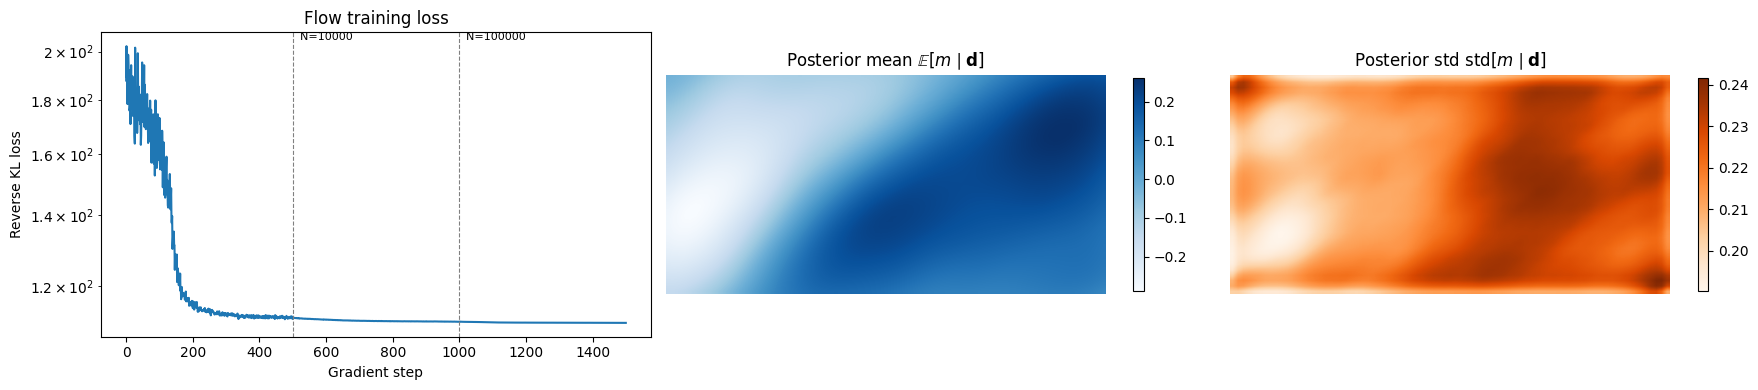


Generated 5000 approximate posterior samples (r = 200).
NOTE: These are surrogate posterior samples from the DINO approximation.
Rigorous validation would require importance-weighted ESS, comparison to
ground-truth MCMC, and correction for surrogate model error. See the
LazyDINO paper (Cao et al., 2024) for details.


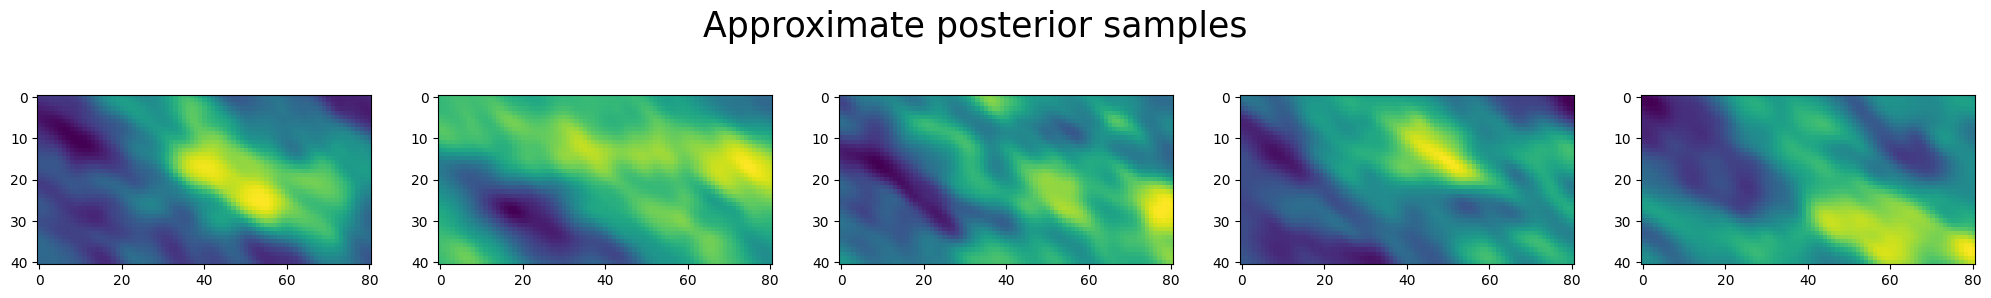

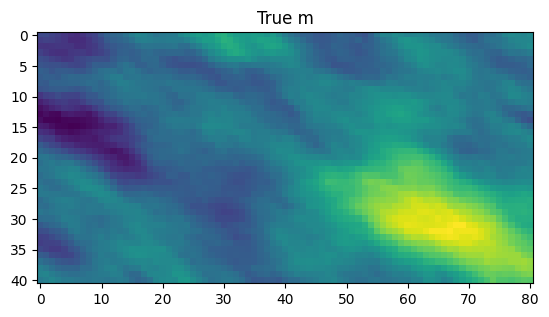

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Training loss
axes[0].semilogy(all_losses)
axes[0].set_xlabel('Gradient step')
axes[0].set_ylabel('Reverse KL loss')
axes[0].set_title('Flow training loss')

# Annotate round boundaries
total = 0
for k, steps_k in enumerate(n_steps_per_round[:-1]):
    total += steps_k
    axes[0].axvline(total, color='gray', ls='--', lw=0.8)
    axes[0].text(total, axes[0].get_ylim()[1], f'  N={sample_sizes[k+1]}',
                 fontsize=8, va='top')

# Posterior mean
im1 = axes[1].imshow(m_mean[reshaper].reshape((ny, nx)),
    extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
    origin='lower', interpolation='bilinear', cmap='Blues', aspect='equal')
axes[1].set_title(r'Posterior mean $\mathbb{E}[m \mid \mathbf{d}]$')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], shrink=0.7)

# Posterior marginal std
im2 = axes[2].imshow(m_std[reshaper].reshape((ny, nx)),
    extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
    origin='lower', interpolation='bilinear', cmap='Oranges', aspect='equal')
axes[2].set_title(r'Posterior std $\mathrm{std}[m \mid \mathbf{d}]$')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], shrink=0.7)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(25, 2.25))
for i, ax in enumerate(axes):
    ax.imshow((z_samples[i] @ jnp.array(decoder).T)[reshaper].reshape((ny, nx)))
fig.suptitle("Approximate posterior samples",fontsize=25, y=1.25)
plt.figure()
plt.imshow(m_array[reshaper].reshape((ny, nx)))
plt.title("True parameter m")
print(f"\nGenerated {n_posterior_samples} approximate posterior samples (r = {r}).")
print("NOTE: These are surrogate posterior samples from the DINO approximation.")
print("Rigorous validation would require importance-weighted ESS, comparison to")
print("ground-truth MCMC, and correction for surrogate model error. See the")
print("LazyDINO paper (Cao et al., 2024) for details.")


Generated 5000 approximate posterior samples (r = 200).
NOTE: These are surrogate posterior samples from the DINO approximation.
Rigorous validation would require importance-weighted ESS, comparison to
ground-truth MCMC, and correction for surrogate model error. See the
LazyDINO paper (Cao et al., 2024) for details.


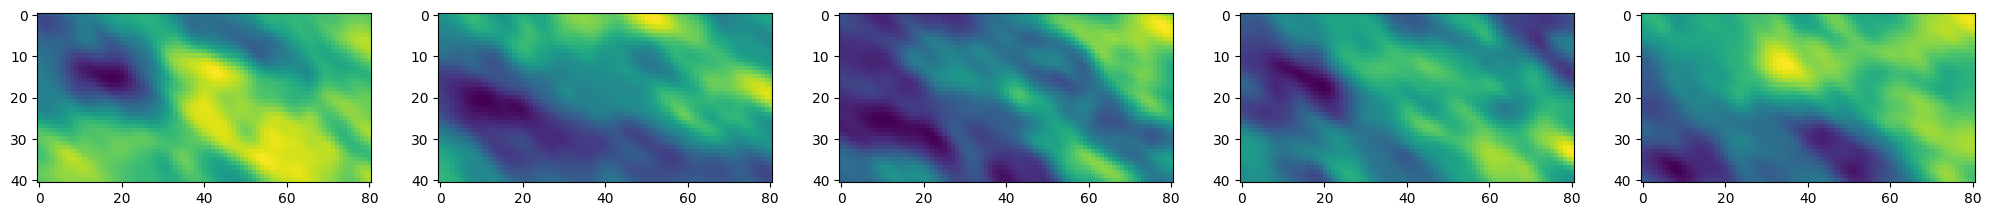

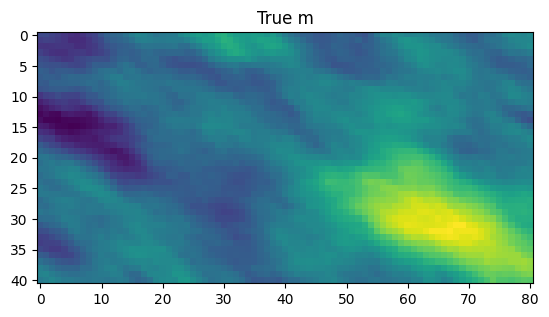